<a href="https://colab.research.google.com/github/435wldms/essa/blob/main/20231127_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01 합성곱 신경망
* 데이터가 가진 특징들의 패턴을 학습하는 알고리즘
* 이미지 분류, 객체 탐지, 스타일 전이

**1-1 이미지 표현**
* 이미지를 컴퓨터가 이해할 수 있게 하기 위해서는 숫자로 표현해야 함
* 0- 255 사이 숫자로 표현하는데 0은 검정 255는 흰색, 그 사이는 회색
* 컬러는 r,g,b 채널로 구성된 3장의 이미지를 겹쳐 표현 -> 0-255 숫자이면서 숫자가 클수록 해당 색상이 더 강함

**1-2 합성곱**
* 입력 이미지에 대하여 정방형 크기를 가지는 커널을 이용해 입력 이미지에 대한 특성을 추출하는 것
* 이렇게 추출된 이미지: 특성맵
* (5x5) shape인 이미지의 좌측 상단부터 커널과 같은 크기를 갖도록 입력 이미지의 일부분에 커널이 겹치도록 투영해 줌 -> 겹치는 부분에 대하여 합성곱 연산 수행
* 커널 사이즈가 3x3 인 경우 9개의 가중치를 가지고 오차 역전파 시 커널의 가중치를 업데이트 (9개에 대해서만 커널의 그래디언트를 업데이트하면 되므로 완전 연결층보다 연산량이 훨씬 작음

**1-3 채널**
* 입력 이미지를 구성하는 2차원 배열의 개수
* 흑백은 채널이 1개, 컬러는 r&g&b로 채널이 3개
* 채널이 여러 개인 경우, 합성곱 연산을 수행할 때 특성 맵의 생성 과정을 잘 살펴보아야 함
* 여러 개의 채널을 가지면 각 채널마다 하나씩 커널을 적용해 합성곱 연산 수행, 이를 통해 입력 이미지의 채널 개수만큼 합성곱 연산된 결과가 생성되고 이들을 다 더해주면 최종 특성맵이 생성
* 합성곱 레이어에 출력 필터의 개수가 20개라면 입력 이미지 체널 개수 3개와 곱해져 60개의 커널이 형성됨, 필터가 3x3인 경우에 총 업데이트할 가중치의 그래디언트는 540개 + bias (출력 필터 개수) 20개 = 560개

**1-4 스트라이드**
* 좌측 상단에서 우측으로 이동하면서 합성곱 연산을 계속 수행하고 특성맵에 결과를 채워나가는데 이때 이동 간격을 스트라이드로 정의
* 텐서플로 케라스에서 제공하는 Conv2D 레이어의 strides 매개변수에 지정

**1-5 패딩**
* 입력 이미지: 5x5, 커널: 3x3, 스트라이드:1인 경우에 추출된 특성맵 사이즈는 입력 이미지 대비 가로와 세로 각각 2픽셀씩 줄어듦 -> 줄어들지 않도록 패딩을 설정
* 보통은 가장 자리에 0으로 채워진 패딩 값으로 채운 후 추출
* padding = 'same'으로 설정

**1-6 특성맵 사이즈**
* 패딩, 스트라이드, 입력 데이터와 필터의 크기가 주어졌을 때 출력 데이터 크기 구할 수 있음

**1-7 풀링**
* 추출된 특성맵에 다운 샘플링하여 이미지의 크기 축소
* 이미지 축소를 통해 연산량 감소 및 과대적합 방지
* 최대 풀링과 평균 풀링이 있는데 주로 최대 풀링을 사용 -> 스트라이드를 2로 설정하면 2칸씩 건너뛰면서 풀링 수행

# 02 간단한 모델 생성
* mnist 데이터

**2-1 데이터 로드 및 전처리**

In [2]:
# tensorflow 모듈 import
import tensorflow as tf

* 훈련 셋 60000개, 검증 셋 10000개, 가로&세로 28 픽셀

In [3]:
# mnist 손글씨 이미지 데이터 로드
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_valid,y_valid) = mnist.load_data()

print(x_train.shape,y_train.shape)
print(x_valid.shape,y_valid.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


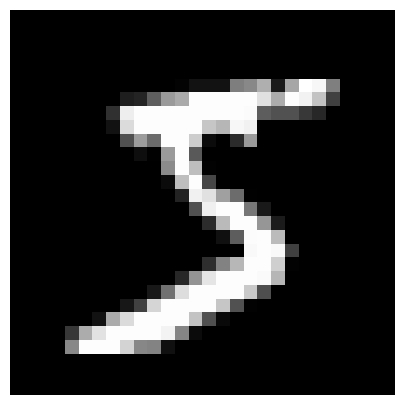

In [4]:
# 샘플 이미지 출력
import matplotlib.pylab as plt

def plot_image(data,idx):
  plt.figure(figsize=(5,5))
  plt.imshow(data[idx],cmap='gray')
  plt.axis('off')
  plt.show()

plot_image(x_train,0)

In [5]:
print(x_train.min(),x_train.max())
print(x_valid.min(),x_valid.max())

0 255
0 255


-> 0-255 범위의 숫자
* 입력 이미지 픽셀 값 정규화 변환

In [6]:
# 정규화
x_train = x_train /255.0
x_valid= x_valid /255.0

print(x_train.min(),x_train.max())
print(x_valid.min(),x_valid.max())

0.0 1.0
0.0 1.0


* mnist는 모노 컬러 이미지 -> cnn 모델에 주입하기 위해 색상을 나타내는 채널 추가

In [7]:
# 채널 추가
print(x_train.shape,x_valid.shape)

x_train_in = x_train[..., tf.newaxis]
x_valid_in = x_valid[..., tf.newaxis]

print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


**2-2 Sequential API로 모델 생성 및 학습**


In [8]:
# Sequential API를 사용해 샘플 모델 생성
model = tf.keras.Sequential([
    # Convolution 적용(32 filters)
    tf.keras.layers.Conv2D(32,(3,3),activation='relu', input_shape=(28,28,1), name='conv'),
    # Max Pooling 적용
    tf.keras.layers.MaxPooling2D((2,2), name='pool'),

    # Classifier 출력층
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
    ])

* 모델 구조에 옵티마이저, 손실함수, 평가지표를 설정하고 컴파일

In [9]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.2099 - accuracy: 0.9406 - val_loss: 0.0828 - val_accuracy: 0.9752
Epoch 2/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0758 - accuracy: 0.9778 - val_loss: 0.0664 - val_accuracy: 0.9792
Epoch 3/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0579 - accuracy: 0.9823 - val_loss: 0.0668 - val_accuracy: 0.9786
Epoch 4/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0474 - accuracy: 0.9852 - val_loss: 0.0694 - val_accuracy: 0.9778
Epoch 5/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0402 - accuracy: 0.9880 - val_loss: 0.0565 - val_accuracy: 0.9815
Epoch 6/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0346 - accuracy: 0.9894 - val_loss: 0.0601 - val_accuracy: 0.9812
Epoch 7/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0290 - accuracy: 0.9913 - val_loss: 0.0568 -

In [10]:
model.evaluate(x_valid_in,y_valid)

313/313 [==============================] - 2s 6ms/step - loss: 0.0593 - accuracy: 0.9837


[0.059268418699502945, 0.9836999773979187]

-> 4 epoch 이후부터는 모델이 과대적합으로 진행됨

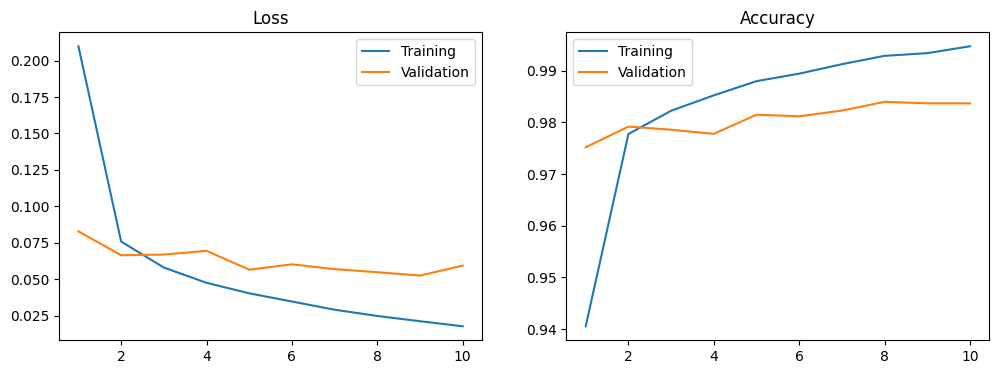

In [11]:
def plot_loss_acc(history, epoch):
  loss, val_loss = history.history['loss'], history.history['val_loss']
  acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

  fig, axes= plt.subplots(1,2,figsize=(12,4))

  axes[0].plot(range(1,epoch+1), loss, label='Training')
  axes[0].plot(range(1,epoch+1), val_loss, label='Validation')
  axes[0].legend(loc='best')
  axes[0].set_title('Loss')

  axes[1].plot(range(1,epoch+1), acc, label='Training')
  axes[1].plot(range(1,epoch+1), val_acc, label='Validation')
  axes[1].legend(loc='best')
  axes[1].set_title('Accuracy')

  plt.show()


plot_loss_acc(history,10)

**2-3 모델 구조 파악**
* summary를 통해 모델의 구조 요약본 볼 수 있음
* 3x3 합성곱 필터를 사용해 원래에 비해 가로, 세로 크기가 2씩 줄어듦 -> 32개의 필터를 적용해 32가지 종류의 피처 추출 -> 2x2 풀링 레이어를 적용해 이미지 크기가 반으로 줄고 이를 1차원 텐서로 펼치면 1차원 벡터가 됨 -> 출력 노드가 10인 dense 레이어로 보내 최종 분류 값 예측 및 출력

In [12]:
# 모델 구조
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv (Conv2D)               (None, 26, 26, 32)        320       
                                                                 
 pool (MaxPooling2D)         (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54410 (212.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# 입력 텐서 형태
model.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

In [14]:
# 출력 텐서 형태
model.output

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense')>

In [15]:
# 레이어
model.layers

-> 4개의 레이어로 구성되고 첫 번째 레이어는 conv2d 레이어

In [16]:
# 첫 번째 레이어 입력
model.layers[0].input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

* conv2d 레이어를 거쳐 픽셀 사이즈는 2씩 줄고 채널 개수는 32개로 늘어남

In [17]:
# 첫 번째 레이어 출력
model.layers[0].output

<KerasTensor: shape=(None, 26, 26, 32) dtype=float32 (created by layer 'conv')>

In [18]:
# 첫 번째 레이어 가중치
model.layers[0].weights

[<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[-0.08693092,  0.2594216 , -0.21395047,  0.07851819,
           -0.29952234,  0.41620576, -0.67288774, -0.6110543 ,
           -0.36236387, -0.8806605 ,  0.3988724 ,  0.17923044,
            0.24802013,  0.32690272,  0.6141954 , -0.50595474,
            0.3291989 ,  0.35927114, -1.5303708 , -0.9365923 ,
            0.23952143,  0.30652657,  0.2508367 , -0.05378658,
            0.24642183,  0.31367737,  0.24695343,  0.2688282 ,
            0.0482566 ,  0.31561148, -0.22879364, -0.3488742 ]],
 
         [[-0.6473735 , -0.33174607, -0.30964473, -0.22968718,
           -0.1968174 ,  0.08307779, -0.23873593,  0.03480025,
           -0.39901513,  0.1323192 ,  0.14950423,  0.2471434 ,
            0.51907367,  0.46488848,  0.41234097,  0.0945395 ,
            0.21165471,  0.0219379 , -0.88597643, -0.9107548 ,
           -0.06571127,  0.2887005 ,  0.02768353, -0.37312174,
            0.2124361 ,  0.2551482 , -0.28

-> 첫 번째 변수는 커널 행렬의 가중치, 두 번째 행렬은 커널의 상수항(bias)
>
-> 커널 가중치의 shape: (3,3,1,32)로, (3,3)은 필터의 크기, (1)은 입력 층의 채널 개수, (32)는 출력 층의 채널 개수
>
-> layer[0]의 학습 가능한 파라미터 수는 3x3x1x32 = 288개이고 상수항까지 더하면 320개 (상수항은 출력층의 채널 수)

* 커널 행렬의 가중치 또는 상수항을 따로 선택

In [19]:
# 첫 번째 레이어 커널 가중치
model.layers[0].kernel

<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
array([[[[-0.08693092,  0.2594216 , -0.21395047,  0.07851819,
          -0.29952234,  0.41620576, -0.67288774, -0.6110543 ,
          -0.36236387, -0.8806605 ,  0.3988724 ,  0.17923044,
           0.24802013,  0.32690272,  0.6141954 , -0.50595474,
           0.3291989 ,  0.35927114, -1.5303708 , -0.9365923 ,
           0.23952143,  0.30652657,  0.2508367 , -0.05378658,
           0.24642183,  0.31367737,  0.24695343,  0.2688282 ,
           0.0482566 ,  0.31561148, -0.22879364, -0.3488742 ]],

        [[-0.6473735 , -0.33174607, -0.30964473, -0.22968718,
          -0.1968174 ,  0.08307779, -0.23873593,  0.03480025,
          -0.39901513,  0.1323192 ,  0.14950423,  0.2471434 ,
           0.51907367,  0.46488848,  0.41234097,  0.0945395 ,
           0.21165471,  0.0219379 , -0.88597643, -0.9107548 ,
          -0.06571127,  0.2887005 ,  0.02768353, -0.37312174,
           0.2124361 ,  0.2551482 , -0.28861925,  0.140567

In [20]:
# 첫 번째 레이어 bias 가중치
model.layers[0].bias

<tf.Variable 'conv/bias:0' shape=(32,) dtype=float32, numpy=
array([-0.00318168, -0.23088115, -0.3417949 , -0.2667188 , -0.00803408,
       -0.03439077, -0.22599673, -0.17415673,  0.00264115, -0.13115512,
       -0.10160296, -0.23964734, -0.00302564, -0.01351653, -0.01040097,
       -0.27673912, -0.31209904, -0.3753085 , -0.01080221, -0.01148545,
       -0.17996308, -0.40101182,  0.23029496, -0.02758353, -0.0124118 ,
       -0.40600047, -0.10172455, -0.37775156, -0.05551088, -0.22272444,
       -0.30429998, -0.35002774], dtype=float32)>

* 레이어의 이름을 사용해 해당 레이어 선택 가능

In [21]:
# 레이어 이름 사용하여 레이어 선택
model.get_layer('conv')

* 모델에 입력 데이터를 넣고 첫 번째와 두 번째 레이어의 출력을 최종 출력으로 갖는 activator 모델 정의
* 첫 번째 샘플에 대해 각 레이어의 출력 예측

In [22]:
# 샘플 이미지의 레이어 별 출력을 리스트에 추가 (첫 번째, 두 번째 레이어)
activator = tf.keras.Model(inputs=model.input, outputs=[layer.output for layer in model.layers[:2]])
activations = activator.predict(x_train_in[0][tf.newaxis, ...])

len(activations)

1/1 [==============================] - 0s 138ms/step


2

In [23]:
# 첫 번째 레이어(conv) 출력층
conv_activation = activations[0]
conv_activation.shape

(1, 26, 26, 32)

-> conv2d 레이어의 출력, 1은 입력 이미지의 개수

* 첫 번째 레이어에서 출력되는 특성맵 이미지를 32개 커널 별로 구분하여 시각화

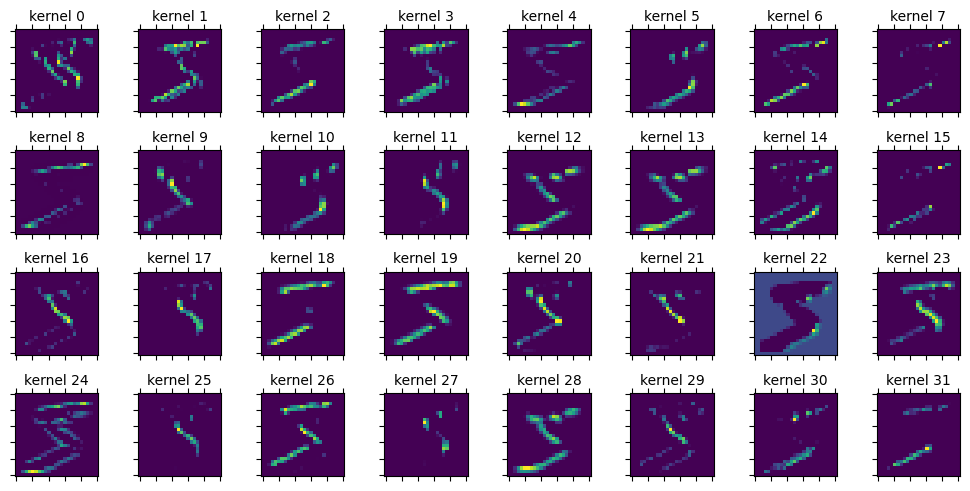

In [26]:
# Convolution 시각화
fig, axes = plt.subplots(4,8)
fig.set_size_inches(10,5)

for i in range(32):
  axes[i//8,i%8].matshow(conv_activation[0,:,:,i],cmap ='viridis') # 첫 번째 레이어(conv)의 i번째 커널의 모든 값을 시각화
  axes[i//8,i%8].set_title('kernel %s'%str(i),fontsize=10)
  plt.setp(axes[i//8,i%8].get_xticklabels(),visible=False)
  plt.setp(axes[i//8,i%8].get_yticklabels(),visible=False)

plt.tight_layout()
plt.show()

-> 커널은 입력 이미지로부터 서로 다른 피처를 추출하는 역할

In [27]:
# 두 번째 레이어(pool) 출력층
pooling_activation = activations[1]
print(pooling_activation.shape)

(1, 13, 13, 32)


-> 이전의 conv2d 출력 이미지에 비해 화소 크기가 굵어짐 (인근 픽셀들을 모아 최대값으로 고정하기 때문)

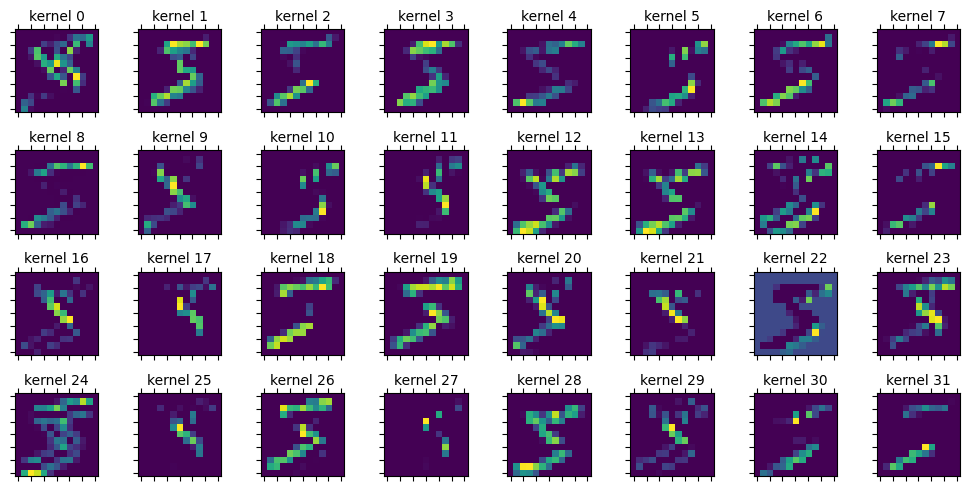

In [28]:
# 시각화
fig, axes = plt.subplots(4,8)
fig.set_size_inches(10,5)

for i in range(32):
  axes[i//8,i%8].matshow(pooling_activation[0,:,:,i],cmap ='viridis') # pooling 레이어의 i번째 커널의 모든 값을 시각화
  axes[i//8,i%8].set_title('kernel %s'%str(i),fontsize=10)
  plt.setp(axes[i//8,i%8].get_xticklabels(),visible=False)
  plt.setp(axes[i//8,i%8].get_yticklabels(),visible=False)

plt.tight_layout()
plt.show()

# 03 복잡한 모델 생성

**3-1 데이터셋 준비**

In [2]:
import tensorflow as tf
import numpy as np

In [3]:
# mnist 손글씨 이미지 데이터 로드
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_valid,y_valid) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


* 0-9까지 숫자를 맞추는 정답 외에 홀수인지 짝수인지 판단하는 정답(y_odd) 추가

In [4]:
# 새로운 출력 값 배열 생성(홀수:1, 짝수:0)
y_train_odd = []
for y in y_train:
  if y % 2 ==0:
    y_train_odd.append(0)
  else:
    y_train_odd.append(1)

y_train_odd = np.array(y_train_odd)
y_train_odd.shape

(60000,)

In [5]:
print(y_train[:10])
print(y_train_odd[:10])

[5 0 4 1 9 2 1 3 1 4]
[1 0 0 1 1 0 1 1 1 0]


* 검증 데이터 셋도 같은 작업 수행

In [6]:
# Validation 데이터셋 처리
y_valid_odd = []
for y in y_valid:
  if y % 2 ==0:
    y_valid_odd.append(0)
  else:
    y_valid_odd.append(1)

y_valid_odd = np.array(y_valid_odd)
y_valid_odd.shape

(10000,)

* 255로 나눠서 정규화, 채널 개수를 1로 지정해 새로운 축 추가
* expand_dims() 함수에 원본 배열을 입력하고 새롭게 추가하려는 축의 인덱스 지정

In [7]:
# 정규화(Normalization)
x_train = x_train/255.0
x_valid = x_valid/255.0

# 채널 추가
x_train_in = tf.expand_dims(x_train,-1)
x_valid_in = tf.expand_dims(x_valid,-1)

print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


**3-2 Functional API로 다중 입력, 다중 출력 레이어 생성**
* Functional API를 사용하면 Sequential과 달리 다중 입력, 출력 구조 가능
* inputs이 conv2d와 flatten 레이어의 입력으로 사용되므로 2개의 출력을 가짐 -> 서로 다른 레이어의 입력으로 사용된 후 concatenate 레이어에서 합쳐진 후에 dense 레이어 통과

In [10]:
# Functional API를 사용하여 모델 생성
inputs = tf.keras.layers.Input(shape=(28,28,1))

conv = tf.keras.layers.Conv2D(32,(3,3), activation='relu')(inputs)
pool = tf.keras.layers.MaxPooling2D(2,2)(conv)
flat = tf.keras.layers.Flatten()(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])
outputs = tf.keras.layers.Dense(10, activation='softmax')(concat)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 26, 26, 32)           320       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 32)           0         ['conv2d_1[0][0]']            
 g2D)                                                                                             
                                                                                                  
 flatten_2 (Flatten)         (None, 5408)                 0         ['max_pooling2d_1[0][0]'] 

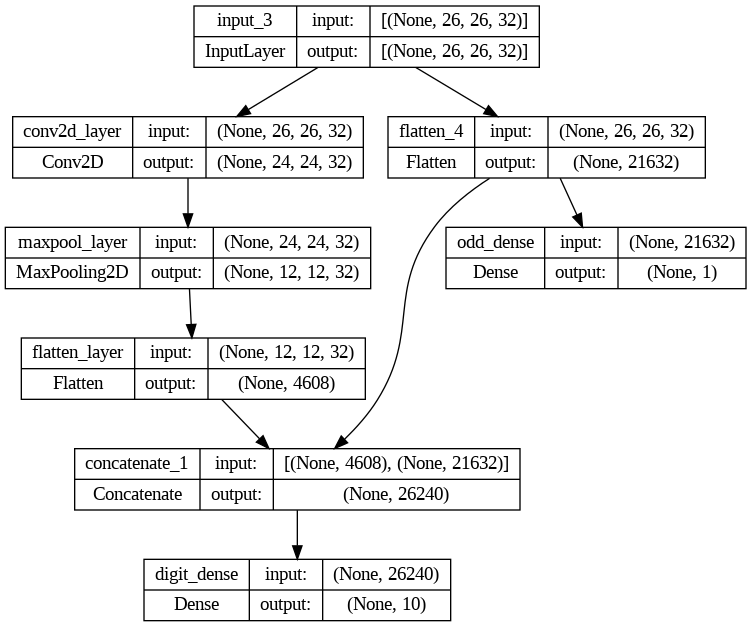

In [18]:
# 모델 구조 출력 및 이미지 파일로 저장
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=True, to_file='functional_cnn.png')

In [13]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid),epochs=10)

# 모델 성능
val_loss, val_acc = model.evaluate(x_valid_in, y_valid)
print(val_loss, val_acc)

Epoch 1/10
1875/1875 [==============================] - 35s 18ms/step - loss: 0.2025 - accuracy: 0.9421 - val_loss: 0.0812 - val_accuracy: 0.9765
Epoch 2/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0776 - accuracy: 0.9777 - val_loss: 0.0606 - val_accuracy: 0.9804
Epoch 3/10
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0598 - accuracy: 0.9823 - val_loss: 0.0599 - val_accuracy: 0.9807
Epoch 4/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0493 - accuracy: 0.9846 - val_loss: 0.0559 - val_accuracy: 0.9824
Epoch 5/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0402 - accuracy: 0.9873 - val_loss: 0.0581 - val_accuracy: 0.9810
Epoch 6/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0343 - accuracy: 0.9895 - val_loss: 0.0536 - val_accuracy: 0.9826
Epoch 7/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0295 - accuracy: 0.9908 - val_loss: 0.0559 -

**3-3 다중 출력 분류 모델**
* 0-9까지의 숫자를 맞추는 분류 문제와 홀수, 짝수를 맞추는 분류 문제를 동시에 풀어내는 모델 정의

In [23]:
# Functional API를 사용해 모델 생성

inputs = tf.keras.layers.Input(shape=(28,28,1),name='inputs')

conv = tf.keras.layers.Conv2D(32,(3,3), activation='relu', name='conv2d_layer')(inputs)
pool = tf.keras.layers.MaxPooling2D((2,2),name='maxpool_layer')(conv)
flat = tf.keras.layers.Flatten(name='flatten_layer')(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])
digit_outputs = tf.keras.layers.Dense(10, activation='softmax', name='digit_dense')(concat)

odd_outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='odd_dense')(flat_inputs)
model = tf.keras.models.Model(inputs=inputs, outputs=[digit_outputs, odd_outputs])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_layer (Conv2D)       (None, 26, 26, 32)           320       ['inputs[0][0]']              
                                                                                                  
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)           0         ['conv2d_layer[0][0]']        
 D)                                                                                               
                                                                                                  
 flatten_layer (Flatten)     (None, 5408)                 0         ['maxpool_layer[0][0]'] 

In [24]:
# 모델의 입력과 출력을 나타내는 텐서
print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'digit_dense')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'odd_dense')>]


-> 입력은 하나, 출력은 10과 1 두 개

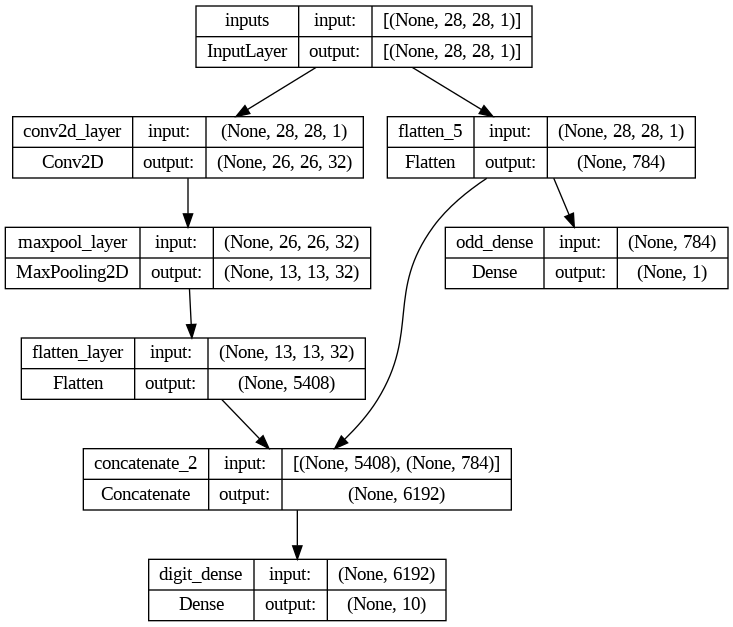

In [25]:
# 모델 구조 그림
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=True, to_file='multi_output_cnn.png')

* 모델 컴파일하는 경우 dense 레이어에 name 속성에 따라 각각 손실함수나 가중치 설정

In [26]:
# 모델 컴파일
model.compile(optimizer='adam', loss={'digit_dense':'sparse_categorical_crossentropy','odd_dense': 'binary_crossentropy'}, loss_weights={'digit_dense':1,'odd_dense':0.5}, metrics=['accuracy'])

# 모델 훈련
history = model.fit({'inputs':x_train_in},
                  {'digit_dense':y_train, 'odd_dense':y_train_odd},
                   validation_data=({'inputs':x_valid_in}, {'digit_dense':y_valid, 'odd_dense':y_valid_odd}), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.3717 - digit_dense_loss: 0.2089 - odd_dense_loss: 0.3256 - digit_dense_accuracy: 0.9413 - odd_dense_accuracy: 0.8641 - val_loss: 0.2220 - val_digit_dense_loss: 0.0846 - val_odd_dense_loss: 0.2747 - val_digit_dense_accuracy: 0.9742 - val_odd_dense_accuracy: 0.8888
Epoch 2/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.2113 - digit_dense_loss: 0.0757 - odd_dense_loss: 0.2713 - digit_dense_accuracy: 0.9777 - odd_dense_accuracy: 0.8917 - val_loss: 0.1955 - val_digit_dense_loss: 0.0638 - val_odd_dense_loss: 0.2634 - val_digit_dense_accuracy: 0.9787 - val_odd_dense_accuracy: 0.8971
Epoch 3/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.1874 - digit_dense_loss: 0.0562 - odd_dense_loss: 0.2623 - digit_dense_accuracy: 0.9837 - odd_dense_accuracy: 0.8960 - val_loss: 0.1872 - val_digit_dense_loss: 0.0570 - val_odd_dense_loss: 0.2604 - val_digit_dense_accuracy: 0.9816 -

In [27]:
# 모델 성능
model.evaluate({'inputs':x_valid_in},{'digit_dense':y_valid,'odd_dense':y_valid_odd})

313/313 [==============================] - 2s 5ms/step - loss: 0.1874 - digit_dense_loss: 0.0588 - odd_dense_loss: 0.2573 - digit_dense_accuracy: 0.9827 - odd_dense_accuracy: 0.9015


[0.1874469667673111,
 0.0588010810315609,
 0.2572919428348541,
 0.982699990272522,
 0.9014999866485596]

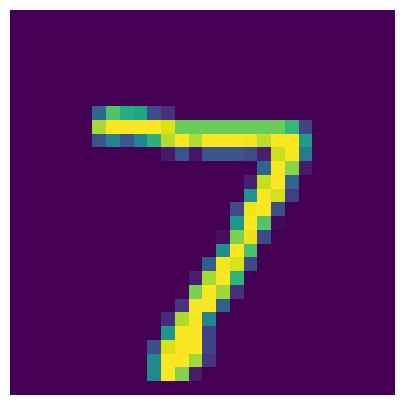

In [28]:
# 샘플 이미지 출력
import matplotlib.pylab as plt

def plot_image(data,idx):
  plt.figure(figsize=(5,5))
  plt.imshow(data[idx])
  plt.axis('off')
  plt.show()

plot_image(x_valid,0)

* 검증 데이터셋의 모든 이미지 데이터를 입력해 두 분류 문제에 대한 예측 확률 구하기

In [29]:
digit_preds, odd_preds = model.predict(x_valid_in)
print(digit_preds[0])
print(odd_preds[0])

313/313 [==============================] - 3s 8ms/step
[2.9685664e-11 2.2767836e-10 1.6811937e-08 2.2545127e-07 7.3893859e-13
 1.0334462e-12 5.2480894e-21 9.9999970e-01 6.7143408e-10 4.7148867e-09]
[0.9994254]


* 예측 확률을 실제 정답 레이블로 변환

In [30]:
digit_labels = np.argmax(digit_preds, axis=1)
digit_labels[0:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

-> 첫 번째 이미지를 7로 잘 예측함
* 홀수, 짝수 여부에 대한 예측 레이블 출력 (threshold를 0.5로 지정)

In [31]:
odd_labels = (odd_preds >0.5).astype(np.int).reshape(1,-1)[0]
odd_labels[0:10]

<ipython-input-31-9c1f25fee548>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  odd_labels = (odd_preds >0.5).astype(np.int).reshape(1,-1)[0]


array([1, 0, 1, 0, 0, 1, 0, 1, 0, 1])

**3-4 전이 학습**
* 기존의 학습된 모델을 사용해 새로운 모델을 만들어내는 것
* 앞에서 학습한 모델에서 입력 레이어부터 'flatten_layer' 층까지 해당하는 부분을 따로 추출해 base_model 객체 만들기


In [32]:
# 앞의 모델에서 flatten_layer 출력을 추출
base_model_output = model.get_layer('flatten_layer').output

# 앞의 출력을 출력으로 하는 모델 정의
base_model = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base')
base_model.summary()

Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320 (1.25 KB)
Trainable params: 320 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


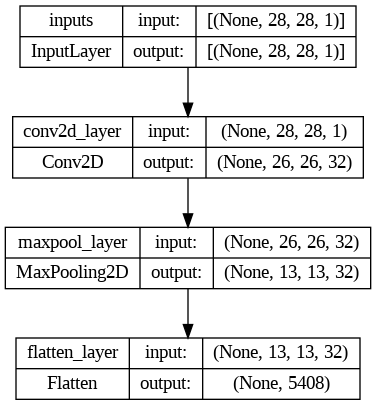

In [33]:
# 모델 구조 출력 및 이미지 파일로 저장
tf.keras.utils.plot_model(base_model,show_shapes=True, show_layer_names=True, to_file='base_model.png')

* base_model을 레이어로 추가하고 dense 레이어 새롭게 이어서 추가

In [35]:
# Sequential API 적용
digit_model = tf.keras.Sequential([
                                  base_model,
                                  tf.keras.layers.Dense(10,activation='softmax')
])
digit_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (Functional)           (None, 5408)              320       
                                                                 
 dense_1 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54410 (212.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


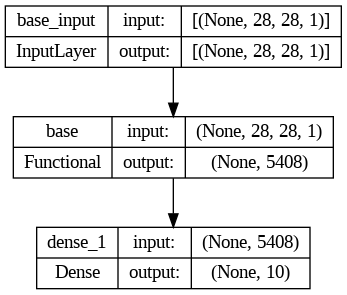

In [36]:
tf.keras.utils.plot_model(digit_model,show_shapes=True, show_layer_names=True, to_file='digit_model.png')

In [37]:
# 모델 컴파일
digit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = digit_model.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid),epochs=10)

Epoch 1/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.1293 - accuracy: 0.9639 - val_loss: 0.0585 - val_accuracy: 0.9823
Epoch 2/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0568 - accuracy: 0.9834 - val_loss: 0.0549 - val_accuracy: 0.9833
Epoch 3/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0419 - accuracy: 0.9875 - val_loss: 0.0559 - val_accuracy: 0.9822
Epoch 4/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0339 - accuracy: 0.9897 - val_loss: 0.0621 - val_accuracy: 0.9811
Epoch 5/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0277 - accuracy: 0.9916 - val_loss: 0.0566 - val_accuracy: 0.9827
Epoch 6/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0222 - accuracy: 0.9932 - val_loss: 0.0585 - val_accuracy: 0.9828
Epoch 7/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0187 - accuracy: 0.9940 - val_loss: 0.0556 -

* trainable = False로 지정 시 파라미터 값이 고정되어 훈련을 통해 업데이트되지 않음

In [38]:
# 베이스 모델의 가중치 고정
base_model_frozen = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base_frozen')
base_model_frozen.trainable = False
base_model_frozen.summary()

Model: "base_frozen"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320 (1.25 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 320 (1.25 KB)
_________________________________________________________________


In [39]:
# Functional API 적용
dense_output = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen.output)
digit_model_frozen = tf.keras.models.Model(inputs=base_model_frozen.input, outputs=dense_output)
digit_model_frozen.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54090 (211.29 KB)
Non-trainable params: 320 (1.25 KB)
_____________________

In [40]:
# 모델 컴파일
digit_model_frozen.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# 모델 훈련
history = digit_model_frozen.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid),epochs=10)

Epoch 1/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1142 - accuracy: 0.9694 - val_loss: 0.0528 - val_accuracy: 0.9827
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0475 - accuracy: 0.9863 - val_loss: 0.0496 - val_accuracy: 0.9846
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0344 - accuracy: 0.9894 - val_loss: 0.0486 - val_accuracy: 0.9835
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0262 - accuracy: 0.9921 - val_loss: 0.0485 - val_accuracy: 0.9843
Epoch 5/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0209 - accuracy: 0.9939 - val_loss: 0.0523 - val_accuracy: 0.9830
Epoch 6/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0171 - accuracy: 0.9949 - val_loss: 0.0506 - val_accuracy: 0.9848
Epoch 7/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0138 - accuracy: 0.9958 - val_loss: 0.0485 - val

* 모델 전체가 아닌 특정 레이어를 지정해 파라미터가 업데이트되지 않도록 고정

In [41]:
# 베이스 모델의 conv2d 레이어의 가중치만 고정
base_model_frozen2 = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base_frozen2')
base_model_frozen2.get_layer('conv2d_layer').trainable=False
base_model_frozen2.summary()

Model: "base_frozen2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320 (1.25 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 320 (1.25 KB)
_________________________________________________________________


In [42]:
# Functional API 적용
dense_output2 = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen2.output)
digit_model_frozen2 = tf.keras.models.Model(inputs=base_model_frozen2.input, outputs=dense_output2)
digit_model_frozen2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54090 (211.29 KB)
Non-trainable params: 320 (1.25 KB)
_____________________

In [43]:
# 모델 컴파일
digit_model_frozen2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# 모델 훈련
history = digit_model_frozen2.fit(x_train_in, y_train, validati on_data=(x_valid_in, y_valid),epochs=10)

Epoch 1/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1147 - accuracy: 0.9692 - val_loss: 0.0586 - val_accuracy: 0.9805
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0472 - accuracy: 0.9861 - val_loss: 0.0529 - val_accuracy: 0.9827
Epoch 3/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0348 - accuracy: 0.9895 - val_loss: 0.0473 - val_accuracy: 0.9856
Epoch 4/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0266 - accuracy: 0.9919 - val_loss: 0.0545 - val_accuracy: 0.9835
Epoch 5/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0207 - accuracy: 0.9937 - val_loss: 0.0557 - val_accuracy: 0.9830
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0171 - accuracy: 0.9948 - val_loss: 0.0487 - val_accuracy: 0.9856
Epoch 7/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0140 - accuracy: 0.9957 - val_loss: 0.0524 - val_ac